In [1]:
import xml.etree.ElementTree as ET
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from os import listdir

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.activations import relu
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Conv2D, Activation, MaxPool2D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import EarlyStopping
from keras import regularizers

C:\Users\VuDinhPhong\Anaconda3\envs\YOLO-env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Define path
CURRENT_WORKING_DIR = os.getcwd()
TRAIN_FOLDER = 'train'
XML_FOLDER = 'localization'

In [4]:
# Matplotlib constant
FIG_SIZE = 15

In [62]:
# Resolation
RESIZE_WIDTH = 512
RESIZE_HEIGHT = 512

CROP_RESIZE_WIDTH = 256
CROP_RESIZE_HEIGHT = 256

CHANNEL = 3

In [5]:
# TRAINING
MODE = 'TEST'

In [69]:
def plot_imgs_with_bounding_box(imgs_arr, bndbox_list=None, imgs_name=None):
    
    fig = plt.figure(figsize=(FIG_SIZE,FIG_SIZE))
    if imgs_name is None:
        imgs_name = np.arange(len(imgs_arr))
        
    _COL = 5
    _ROW = (len(imgs_arr)/_COL) + 1

    
    for i,im in enumerate(imgs_arr):
        
        ax = fig.add_subplot(_ROW, _COL, i+1)
        
        ax.set_title(imgs_name[i])
        
        if bndbox_list:
            # Create a Rectangle patch
            bx = bndbox_list[i][0]
            by = bndbox_list[i][1]
            bwidth = bndbox_list[i][2]-bx
            bheight = bndbox_list[i][3]-by
            rect = patches.Rectangle((bx,by),bwidth,bheight,linewidth=2,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
        ax.imshow(im, cmap='gray')
        

In [75]:
def plot_imgs_random(imgs_arr, bndbox_list=None, imgs_name=None, num_sample=5):

    rnd = np.random.choice(np.arange(test.shape[0]), num_sample, replace=False)
    plot_imgs_with_bounding_box(imgs_arr[rnd], bndbox_list, imgs_name)

In [7]:
def read_data_from_xml_folder(path):
    xml_files = listdir(path)
    train_data = []
    labels = []
    for _d in xml_files:
        d_tree = ET.parse(os.path.join(path,_d))
        d_root = d_tree.getroot()
        
        # Load training data
        file_path = d_root.find('path').text
        img = cv2.imread(file_path)
        img = cv2.resize(img, (RESIZE_WIDTH, RESIZE_HEIGHT))
        img = img.reshape(1, RESIZE_WIDTH, RESIZE_HEIGHT, 3)
        train_data.append(img)
        
        # Read image size
        img_size = d_root.find('size')
        img_width = int(img_size.find('width').text)
        img_height = int(img_size.find('height').text)
        
        scale_width = RESIZE_WIDTH/img_width
        scale_height = RESIZE_HEIGHT/img_height
        
        # Process bounding box label
        
        object_= d_root.find('object')
        bndbox = object_.find('bndbox')
        xmin = round(int(bndbox.find('xmin').text) * scale_width)
        ymin = round(int(bndbox.find('ymin').text) * scale_height)
        xmax = round(int(bndbox.find('xmax').text) * scale_width)
        ymax = round(int(bndbox.find('ymax').text) * scale_height)
        
        rectangular = np.array([xmin, ymin, xmax, ymax])
        labels.append(rectangular)
        
    train_data = np.vstack(train_data)
    labels = np.vstack(labels)
    
    print("training shape: ", train_data.shape)
    print("label shape: ",  labels.shape)
    
    return train_data, labels
    

In [8]:
train_data, labels = read_data_from_xml_folder(os.path.join(CURRENT_WORKING_DIR, XML_FOLDER))

training shape:  (551, 512, 512, 3)
label shape:  (551, 4)


# Plot some images


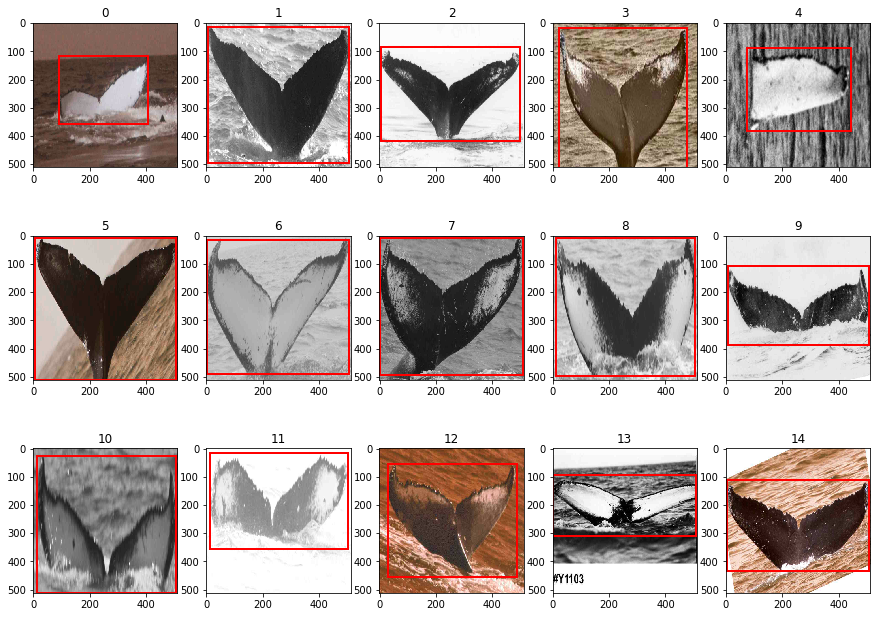

In [9]:
num_sample = 15
rnd = np.random.choice(np.arange(train_data.shape[0]), num_sample, replace=False)
plot_imgs_with_bounding_box(train_data[rnd], labels[rnd])

# Prepare Data Generator

In [10]:
train_data_gen = ImageDataGenerator(featurewise_center=True,rotation_range=5,width_shift_range=5, validation_split=0.2)
train_data_gen.fit(train_data)

# Prepare Network

In [11]:
def base_model():
    model = Sequential()

    model.add(Conv2D(input_shape=(RESIZE_WIDTH, RESIZE_HEIGHT, 3), filters=32, kernel_size=3, ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())

    model.add(Conv2D(filters=32, kernel_size=3, ))
    model.add(BatchNormalization())

    model.add(Activation('relu'))
    model.add(MaxPool2D())

    model.add(Conv2D(filters=64, kernel_size=3, ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())

    model.add(Conv2D(filters=64, kernel_size=3, ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())

    model.add(Conv2D(filters=64, kernel_size=3, ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())

    model.add(Flatten())
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dense(4,))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [12]:
model = base_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 510, 510, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 510, 510, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 510, 510, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 253, 253, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 253, 253, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 253, 253, 32)      0         
__________

In [13]:
if MODE == 'TRAIN':
    model.fit_generator(generator=train_data_gen.flow(train_data, labels, batch_size=32, subset='training'), 
                        steps_per_epoch=32, epochs=120, 
                        validation_data=train_data_gen.flow(train_data, labels, subset='validation'), 
                        callbacks=[EarlyStopping(patience=30)])
    model.save_weights('localization_weight')
else:
    model.load_weights('localization_weight')

In [14]:
def load_imgs_from_folder(folder, filenames=None, load_size=-1):
    """
        Read images into a numpy array
        Input: 
            - folder: a path
            - filenames: list of images name in folder
            - load_size: number of image to read
                    + -1: read all
                    + other
    """
    imgs = []
    file_names = filenames if filenames is not None else listdir(folder)
    for i, f in enumerate(file_names):
        if i == load_size:
            break
        img = cv2.imread(os.path.join(folder, f))
        img = cv2.resize(img, (RESIZE_WIDTH, RESIZE_HEIGHT))
        img = img.reshape(1, RESIZE_WIDTH, RESIZE_HEIGHT, 3)
        imgs.append(img)
    imgs = np.vstack(imgs)
    return imgs

In [15]:
test = load_imgs_from_folder(os.path.join(CURRENT_WORKING_DIR, TRAIN_FOLDER),load_size=3000)

In [16]:
pred = np.rint(model.predict(test))
pred[:]

array([[ 34.,  54., 461., 337.],
       [ 47., 136., 405., 354.],
       [  1., -12., 514., 474.],
       ...,
       [  3.,  56., 509., 404.],
       [ -1.,  12., 518., 513.],
       [ 13., 116., 461., 474.]], dtype=float32)

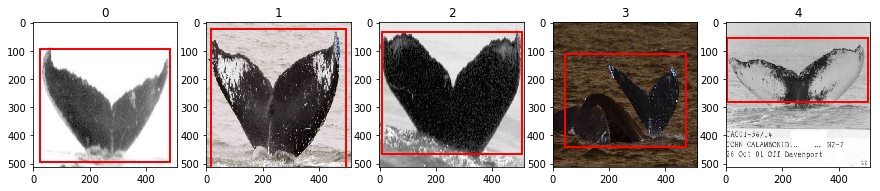

In [17]:
num_sample = 5
rnd = np.random.choice(np.arange(test.shape[0]), num_sample, replace=False)
plot_imgs_with_bounding_box(test[rnd], pred[rnd])

In [63]:
def crop_image(data, regions):
    regions[regions < 0] = 0
    regions[regions > RESIZE_WIDTH] = RESIZE_WIDTH
    regions = regions.astype(int)
    cropped_img_list = []
    for d_, box in zip(data, regions):
        cropped_d = d_[box[1]:box[3],box[0]:box[2]:]
        img = cv2.resize(cropped_d, (CROP_RESIZE_WIDTH, CROP_RESIZE_HEIGHT))
        img = img.reshape(1, CROP_RESIZE_WIDTH, CROP_RESIZE_HEIGHT,CHANNEL)
        
        cropped_img_list.append(img)
    cropped_img_arr = np.vstack(cropped_img_list)
    return cropped_img_arr

In [72]:
cropped = crop_image(test, pred)

In [73]:
cropped.shape

(3000, 256, 256, 3)

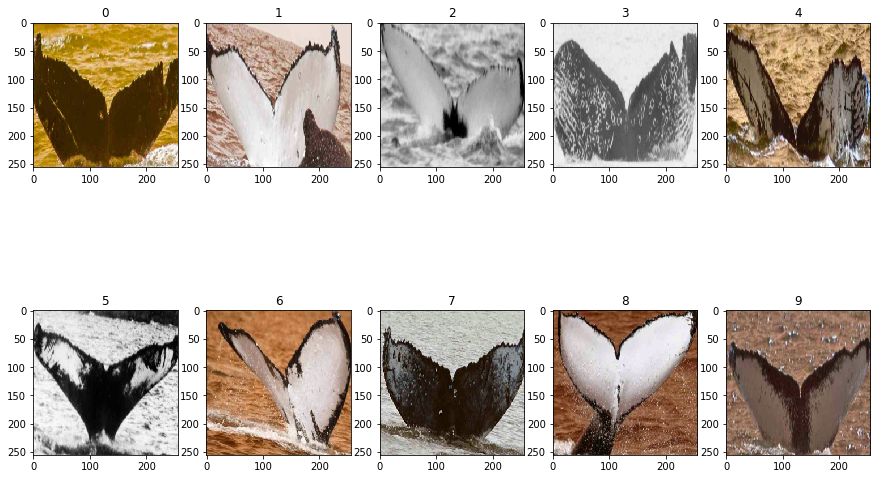

In [78]:
plot_imgs_random(cropped, num_sample=10)